In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from numba import jit
import quantecon as qe

I wrote two different interpolation functions: first is based on for loop and second is a vectorized function. It turns out my vectorized function 'numbainterp_vec" beats the Numpy.interp but for-loop based doesn't. Please see details below.
The time results of Coleman operator( and EGM) is at the very end.

In [2]:
@jit
def numbainterp(x, xp, fp):
    '''
    numbainterp is a function optimized by Numba based on for loop structure

    '''
    order = np.argsort(xp)
    xp = np.array(xp)[order]
    fp = np.array(fp)[order]
    x = np.array(x)
    y = np.zeros_like(x)
    for i in range(len(x)):
        if x[i] > xp[-1]:
            y[i] = fp[-1]
            #y[i] = fp[-1] + (fp[-1] - fp[-2])/(xp[-1] - xp[-2])*(x[i] - xp[-1])
        elif x[i] < xp[0]:
            y[i] = fp[0]
            #y[i] = fp[0] + (fp[1]- fp[0])/(xp[1] - xp[0])*(x[i] - xp[0])
        for j in range(0, (len(xp)-1)):
            if xp[j] == x[i]:
                y[i] = fp[j]
            elif xp[j] < x[i] and xp[j+1]> x[i]:
                y[i] = (fp[j+1]- fp[j])/(xp[j+1]-xp[j])*(x[i] - xp[j]) + fp[j]

    return(y)

In [3]:
@jit
def numbainterp_vec(x, xp, fp):
    '''
    numbainterp_vec is a function based on vectorization optimized by Numba

    '''
    xp = np.array(xp)
    fp = np.array(fp)
    x = np.array(x)
    slope  =  (fp[1:] - fp[:-1])/(xp[1:] - xp[:-1])
    index = np.digitize(x, xp, right = True)
    result = fp[index-1] + slope[index-1]*(x - xp[index-1])
    
    

    return(result)

In [4]:
xp = [1, 2, 3, 5, 6, 7, 8, 9 ]
fp = [3, 2, 0, 4, 5, 3, 7, 9]
x = [2.5, 3.5, 4.5, 5.5, 6.7, 8.9, 7.4, 5.9, 6.2, 1.7]
print("Checking whether the linear interpolaton method returns the same result:\n")
print(np.interp(x, xp, fp))
print(numbainterp(x, xp, fp))
print(numbainterp_vec(x, xp, fp))

Checking whether the linear interpolaton method returns the same result:

[ 1.   1.   3.   4.5  3.6  8.8  4.6  4.9  4.6  2.3]
[ 1.   1.   3.   4.5  3.6  8.8  4.6  4.9  4.6  2.3]
[ 1.   1.   3.   4.5  3.6  8.8  4.6  4.9  4.6  2.3]


In [5]:
print("time for Numpy interpolation:")
%timeit np.interp(x, xp, fp)
print("time for function based on for loop:")
%timeit numbainterp(x, xp, fp)
print("time for vectorized function:")
%timeit numbainterp_vec(x, xp, fp)

time for Numpy interpolation:
5.73 µs ± 421 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
time for function based on for loop:
24.3 µs ± 2.67 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
time for vectorized function:
4.69 µs ± 110 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


The results below shows my vectorized function beats numpy.interp

In [6]:
# using numba to speed up the Endogenized Grid Method code
# coleman operator
def coleman_operator(g, grid, beta, u_prime, f, f_prime, shocks, interp, Kg=None):
    """
    The approximate Coleman operator, which takes an existing guess g of the
    optimal consumption policy and computes and returns the updated function
    Kg on the grid points.  An array to store the new set of values Kg is
    optionally supplied (to avoid having to allocate new arrays at each
    iteration).  If supplied, any existing data in Kg will be overwritten.

    Parameters
    ----------
    g : array_like(float, ndim=1)
        The value of the input policy function on grid points
    grid : array_like(float, ndim=1)
        The set of grid points
    beta : scalar
        The discount factor
    u_prime : function
        The derivative u'(c) of the utility function
    f : function
        The production function f(k)
    f_prime : function
        The derivative f'(k)
    shocks : numpy array
        An array of draws from the shock, for Monte Carlo integration (to
        compute expectations).
    interp: scalar
        1: np.interp; 2: numbainterp; 3: numbainterp_vec
    Kg : array_like(float, ndim=1) optional (default=None)
        Array to write output values to

    """
    # === Apply linear interpolation to g === #
    if interp == 1:
        g_func = lambda x: np.interp(x, grid, g)
    elif interp == 2:
        g_func = lambda x: numbainterp(x, grid, g)
    elif interp ==3:
        g_func = lambda x: numbainterp_vec(x, grid, g)

    # == Initialize Kg if necessary == #
    if Kg is None:
        Kg = np.empty_like(g)

    # == solve for updated consumption value
    for i, y in enumerate(grid):
        def h(c):
            vals = u_prime(g_func(f(y - c) * shocks)) * f_prime(y - c) * shocks
            return u_prime(c) - beta * np.mean(vals)
        c_star = brentq(h, 1e-10, y - 1e-10)
        Kg[i] = c_star

    return Kg

#endogenous grid method
def coleman_egm(g, k_grid, beta, u_prime, u_prime_inv, f, f_prime, shocks, interp):
    """
    The approximate Coleman operator, updated using the endogenous grid
    method.

    Parameters
    ----------
    g : function
        The current guess of the policy function
    k_grid : array_like(float, ndim=1)
        The set of *exogenous* grid points, for capital k = y - c
    beta : scalar
        The discount factor
    u_prime : function
        The derivative u'(c) of the utility function
    u_prime_inv : function
        The inverse of u' (which exists by assumption)
    f : function
        The production function f(k)
    f_prime : function
        The derivative f'(k)
    shocks : numpy array
        An array of draws from the shock, for Monte Carlo integration (to
        compute expectations).
    interp: scalar
        1: np.interp; 2: numbainterp; 3: numbainterp_vec
    """

    # Allocate memory for value of consumption on endogenous grid points
    c = np.empty_like(k_grid)

    # Solve for updated consumption value
    for i, k in enumerate(k_grid):
        vals = u_prime(g(f(k) * shocks)) * f_prime(k) * shocks
        c[i] = u_prime_inv(beta * np.mean(vals))

    # Determine endogenous grid
    y = k_grid + c  # y_i = k_i + c_i

    # Update policy function and return
    if interp == 1:
        Kg = lambda x: np.interp(x, y, c)
    elif interp == 2:
        Kg = lambda x: numbainterp(x, y, c)
    elif interp == 3:
        Kg = lambda x: numbainterp_vec(x, y, c)
    

    return Kg


In [7]:
class LogLinearOG:
    """
    Log linear optimal growth model, with log utility, CD production and
    multiplicative lognormal shock, so that

        y = f(k, z) = z k^alpha

    with z ~ LN(mu, s).

    The class holds parameters and true value and policy functions.
    """

    def __init__(self, alpha=0.4, beta=0.96, mu=0, s=0.1):

        self.alpha, self.beta, self.mu, self.s = alpha, beta, mu, s

        # == Some useful constants == #
        self.ab = alpha * beta
        self.c1 = np.log(1 - self.ab) / (1 - beta)
        self.c2 = (mu + alpha * np.log(self.ab)) / (1 - alpha)
        self.c3 = 1 / (1 - beta)
        self.c4 = 1 / (1 - self.ab)

    def u(self, c):
        " Utility "
        return np.log(c)

    def u_prime(self, c):
        return 1 / c

    def f(self, k):
        " Deterministic part of production function.  "
        return k**self.alpha

    def f_prime(self, k):
        return self.alpha * k**(self.alpha - 1)

    def c_star(self, y):
        " True optimal policy.  "
        return (1 - self.alpha * self.beta) * y

    def v_star(self, y):
        " True value function. "
        return self.c1 + self.c2 * (self.c3 - self.c4) + self.c4 * np.log(y)


In [8]:
lg = LogLinearOG()

# == Unpack parameters / functions for convenience == #
alpha, beta, mu, s = lg.alpha, lg.beta, lg.mu, lg.s
v_star, c_star = lg.v_star, lg.c_star
u, u_prime, f, f_prime = lg.u, lg.u_prime, lg.f, lg.f_prime

In [9]:
grid_max = 4         # Largest grid point, exogenous grid
grid_size = 200      # Number of grid points
shock_size = 250     # Number of shock draws in Monte Carlo integral

k_grid = np.linspace(1e-5, grid_max, grid_size)
shocks = np.exp(mu + s * np.random.randn(shock_size))

TOC: Elapsed: 0.004001140594482422 seconds.


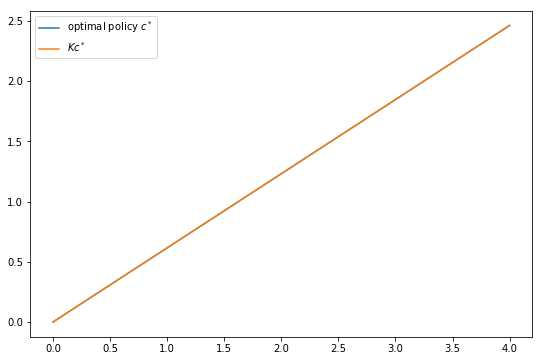

In [10]:
qe.util.tic()
c_star_new = coleman_egm(c_star,
            k_grid, beta, u_prime, u_prime, f, f_prime, shocks, 1)
qe.util.toc()
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(k_grid, c_star(k_grid), label="optimal policy $c^*$")
ax.plot(k_grid, c_star_new(k_grid), label="$Kc^*$")

ax.legend(loc='upper left')
plt.show()


TOC: Elapsed: 0.6554281711578369 seconds.


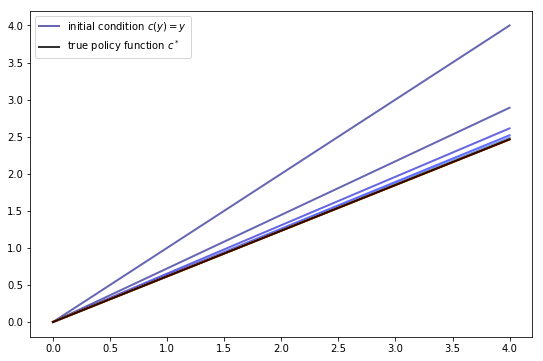

In [11]:
g = lambda x: x
n = 15
fig, ax = plt.subplots(figsize=(9, 6))
lb = 'initial condition $c(y) = y$'

ax.plot(k_grid, g(k_grid), color=plt.cm.jet(0), lw=2, alpha=0.6, label=lb)
qe.util.tic()
for i in range(n):
    new_g = coleman_egm(g, k_grid, beta, u_prime, u_prime, f, f_prime, shocks, 3)
    g = new_g
    ax.plot(k_grid, g(k_grid), color=plt.cm.jet(i / n), lw=2, alpha=0.6)
qe.util.toc()
lb = 'true policy function $c^*$'
ax.plot(k_grid, c_star(k_grid), 'k-', lw=2, alpha=0.8, label=lb)
ax.legend(loc='upper left')

plt.show()

In [12]:
## Define the model

alpha = 0.65
beta = 0.95
mu = 0
s = 0.1
grid_min = 1e-6
grid_max = 4
grid_size = 200
shock_size = 250

gamma = 1.5   # Preference parameter
gamma_inv = 1 / gamma

def f(k):
    return k**alpha

def f_prime(k):
    return alpha * k**(alpha - 1)

def u(c):
    return (c**(1 - gamma) - 1) / (1 - gamma)

def u_prime(c):
    return c**(-gamma)

def u_prime_inv(c):
    return c**(-gamma_inv)

k_grid = np.linspace(grid_min, grid_max, grid_size)
shocks = np.exp(mu + s * np.random.randn(shock_size))

## Let's make convenience functions based around these primitives

def crra_coleman(g, interp):
    return 


def crra_coleman_egm(g, interp):
    return coleman_egm(g, k_grid, beta, u_prime, u_prime_inv, f, f_prime, shocks, interp)

In [13]:
sim_length = 20

print("When using np.interp:\n")
interp = 1
print("Timing standard Coleman policy function iteration")
g_init = k_grid
g = g_init
qe.util.tic()
for i in range(sim_length):
    new_g = crra_coleman(g, interp)
    g = new_g
qe.util.toc()


print("Timing policy function iteration with endogenous grid")
g_init_egm = lambda x: x
g = g_init_egm
qe.util.tic()
for i in range(sim_length):
    new_g = crra_coleman_egm(g, interp)
    g = new_g
qe.util.toc()

print("\n")
print("When using vectorized interpolation function(Numbafied):\n")
interp = 3
print("Timing standard Coleman policy function iteration")
g_init = k_grid
g = g_init
qe.util.tic()
for i in range(sim_length):
    new_g = crra_coleman(g, interp)
    g = new_g
qe.util.toc()


print("Timing policy function iteration with endogenous grid")
g_init_egm = lambda x: x
g = g_init_egm
qe.util.tic()
for i in range(sim_length):
    new_g = crra_coleman_egm(g, interp)
    g = new_g
qe.util.toc()

print("\n")
print("When using for-loop interpolation function(Numbafied):\n")
interp = 2
print("Timing standard Coleman policy function iteration")
g_init = k_grid
g = g_init
qe.util.tic()
for i in range(sim_length):
    new_g = crra_coleman(g, interp)
    g = new_g
qe.util.toc()


print("Timing policy function iteration with endogenous grid")
g_init_egm = lambda x: x
g = g_init_egm
qe.util.tic()
for i in range(sim_length):
    new_g = crra_coleman_egm(g, interp)
    g = new_g
qe.util.toc()

When using np.interp:

Timing standard Coleman policy function iteration
TOC: Elapsed: 0.0 seconds.
Timing policy function iteration with endogenous grid
TOC: Elapsed: 0.15795516967773438 seconds.


When using vectorized interpolation function(Numbafied):

Timing standard Coleman policy function iteration
TOC: Elapsed: 0.0 seconds.
Timing policy function iteration with endogenous grid
TOC: Elapsed: 0.27386951446533203 seconds.


When using for-loop interpolation function(Numbafied):

Timing standard Coleman policy function iteration
TOC: Elapsed: 0.0 seconds.
Timing policy function iteration with endogenous grid
TOC: Elapsed: 0.9368553161621094 seconds.


0.9368553161621094